In [1]:
with open('data/datasets/Yandex/corpus.en_ru.1m.en', 'r') as file:
    english_text = file.readlines()

In [2]:
with open('data/datasets/Yandex/corpus.en_ru.1m.ru', 'r') as file:
    russian_text = file.readlines()


In [3]:
russian_text = list(map(lambda x: x.replace('\n', ''), russian_text))
english_text = list(map(lambda x: x.replace('\n', ''), english_text))

In [157]:
import re

add_space_fn = lambda sen: re.sub("[1234567890]", lambda group: " " + group[0] + " ", sen).replace('  ', ' ')

In [158]:
add_space_fn('asd534')

'asd 5 3 4 '

In [78]:
import string

In [9]:
import re


string = "you can edit account closures from the sap easy access screen under account management ® account ® account master data ® close account.\n"
string_without_letters = re.sub(r"![a-z+а-я+0-9+ +,\-.'\[\]():%\"$]", '', string.lower())
string_without_letters

'you can edit account closures from the sap easy access screen under account management ® account ® account master data ® close account.\n'

In [14]:
add_space_fn = lambda sen: re.sub("[1234567890\-/)(]", lambda group: " " + group[0] + " ", sen).replace('  ', ' ')

In [15]:
add_space_fn(' asd-d/()')

' asd - d / ( ) '

In [216]:
string = "ыфваывав ® account ® account master data ® close account.\n"
string_without_letters = re.sub(r"[^\u0400–\u04FF]", '', string.lower())
string_without_letters

''

In [17]:
russian_text_ = list(map(lambda x: add_space_fn(x), russian_text))
english_text_ = list(map(lambda x: add_space_fn(x), english_text))

In [73]:
filter_result = filter(lambda x: abs(len(x[0]) - len(x[1])) / max(len(x[0]), len(x[1])) > 0.40, zip(english_text, russian_text))

In [58]:
filter_result = filter(lambda x: x[0] == x[1], zip(english_text, russian_text))

In [272]:
filter_result = map(lambda x: re.sub(r"[a-z+а-я+0-9+ +,\-.'\[\]():%\"$?/!]", '', x.lower()), ru)

In [273]:
bad_examples = list(filter_result)
len(bad_examples)

936205

In [274]:
bad_examples = list(filter(lambda x: len(x) > 0, bad_examples))
len(bad_examples)

638

In [275]:
''.join(set(''.join(bad_examples)))

'\\'

In [245]:
pattern = re.compile(f"[{''.join(set(''.join(bad_examples)))}]")

In [247]:
%%timeit
re.sub(pattern, '', string)

4.42 µs ± 73.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [269]:
ru, en = russian_text, english_text
# Remove all unusual characters and transform to lower case
ru = map(lambda x: re.sub(r"![а-я+0-9+ +,\-.'\[\]():%\"$?/!]", '', x.lower()), ru)
en = map(lambda x: re.sub(r"![a-z+0-9+ +,\-.'\[\]():%\"$?/!]", '', x.lower()), en)

# Add spaces between digits so that digit sequences do not pollute vocabularies
add_space_fn = lambda sen: re.sub("[1234567890\-\\]", lambda group: " " + group[0] + " ", sen).replace('  ', ' ')
ru = map(add_space_fn, ru)
en = map(add_space_fn, en)

# Remove pairs of sentences which lenghts are too different (one sentences is at least 1.4 times bigger than the other)
filter_result = filter(lambda x: abs(len(x[0]) - len(x[1])) / max(len(x[0]), len(x[1]), 1) < 0.40 and len(x[0]) > 0 and len(x[1]) > 0, zip(ru, en))

ru_filtered = []
en_filtered = []
_ = [(ru_filtered.append(ru_sen), en_filtered.append(en_sen)) for ru_sen, en_sen in filter_result]

# Gather unicode characters and remove them from the text
print('Removing special characters...')

def gather_specials(text) -> set:
    specials_map = map(lambda x: re.sub(r"[a-z+а-я+0-9+ +,\-.'\[\]():%\"$?/!]", '', x.lower()), text)
    specials_list = list(filter(lambda x: len(x) > 0, specials_map))
    return set(''.join(specials_list))
    
en_specials = gather_specials(en_filtered)
ru_specials = gather_specials(ru_filtered)
specials = en_specials.union(ru_specials)
specials_pattern = re.compile(f"[{''.join(specials)}]")
specials_delete_fn = lambda sen: re.sub(specials_pattern, '', sen).replace('  ', ' ')
ru = list(map(specials_delete_fn, ru_filtered))
en = list(map(specials_delete_fn, en_filtered))

Removing special characters...


In [282]:
print(len(en))
len(list(filter(lambda x: len(x) > 5, en)))

936205


936188

In [6]:
import spacy
en_tokenizer = spacy.load("en_core_web_sm")
ru_tokenizer = spacy.load('ru_core_news_sm')
# Disable all of the unnecessary pipes to accelerate the data pipeline.
en_tokenizer.disable_pipes(['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])
ru_tokenizer.disable_pipes(['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [ ]:
print(english_text[-1].decode('utf-8', 'ignore'))

23 The KWrite Handbook Tools → Encoding You can overwrite the default encoding set in Settings → Congure Editor... in the Open/Save page to set a different encoding for your current document.



In [283]:
import os
import re

class YandexDataset:
    RU_TEXT_FILENAME = 'corpus.en_ru.1m.ru'
    EN_TEXT_FILENAME = 'corpus.en_ru.1m.en'

    def __init__(self, data_folder, train_split=0.95, valid_split=0.025, test_split=0.025):
        with open(os.path.join(data_folder, YandexDataset.EN_TEXT_FILENAME), 'r') as file:
            self.english_text = file.readlines()

        with open(os.path.join(data_folder, YandexDataset.RU_TEXT_FILENAME), 'r') as file:
            self.russian_text = file.readlines()

        self.train_split = train_split
        self.valid_split = valid_split
        self.test_split = test_split

        self.filter_data()

    def filter_data(self):
        print('Filtering the dataset. Initial size: %d' % len(self.russian_text))
        ru, en = russian_text, english_text
        # Remove all unusual characters and transform to lower case
        ru = map(lambda x: re.sub(r"![а-я+0-9+ +,\-.'\[\]():%\"$?/!]", '', x.lower()), ru)
        en = map(lambda x: re.sub(r"![a-z+0-9+ +,\-.'\[\]():%\"$?/!]", '', x.lower()), en)

        # Add spaces between digits so that digit sequences do not pollute vocabularies
        add_space_fn = lambda sen: re.sub("[1234567890]", lambda group: " " + group[0] + " ", sen).replace('  ', ' ')
        ru = map(add_space_fn, ru)
        en = map(add_space_fn, en)

        # Remove pairs of sentences which lenghts are too different (one sentences is at least 1.4 times bigger than the other)
        filter_result = filter(lambda x: abs(len(x[0]) - len(x[1])) / max(len(x[0]), len(x[1]), 1) < 0.40 and len(x[0]) > 0 and len(x[1]) > 0, zip(ru, en))

        ru_filtered = []
        en_filtered = []
        _ = [(ru_filtered.append(ru_sen), en_filtered.append(en_sen)) for ru_sen, en_sen in filter_result]

        # Gather unicode characters and remove them from the text
        print('Removing special characters...')

        def gather_specials(text) -> set:
            specials_map = map(lambda x: re.sub(r"[a-z+а-я+0-9+ +,\-.'\[\]():%\"$?/!]", '', x.lower()), text)
            specials_list = list(filter(lambda x: len(x) > 0, specials_map))
            return set(''.join(specials_list))
            
        en_specials = gather_specials(en_filtered)
        ru_specials = gather_specials(ru_filtered)
        specials = en_specials.union(ru_specials)
        specials_pattern = re.compile(f"[{''.join(specials)}]")
        specials_delete_fn = lambda sen: re.sub(specials_pattern, '', sen).replace('  ', ' ')
        ru = list(map(specials_delete_fn, ru_filtered))
        en = list(map(specials_delete_fn, en_filtered))

        assert len(ru_filtered) == len(en_filtered)
        self.russian_text = ru
        self.english_text = en
        
        print('Filtered successfully. Final size: %d' % len(ru_filtered))

    def __len__(self):
        return len(self.english_text)

    def __iter__(self):
        for en, ru in zip(self.english_text, self.russian_text):
            yield en, ru

    def train_iter(self):
        train_end_ind = int(len(self.english_text) * self.train_split)
        for en, ru in zip(self.english_text[:train_end_ind], self.russian_text[:train_end_ind]):
            yield en, ru
    
    def valid_iter(self):
        valid_start_ind = int(len(self.english_text) * self.train_split)
        valid_end_ind = int(len(self.english_text) * (self.train_split + self.valid_split))

        english_sub_text = self.english_text[valid_start_ind:valid_end_ind]
        russian_sub_text = self.russian_text[valid_start_ind:valid_end_ind]
        for en, ru in zip(english_sub_text, russian_sub_text):
            yield en, ru

    def test_iter(self):
        test_start_ind = int(len(self.english_text) * (self.train_split + self.valid_split))
        test_end_ind = len(self.english_text)

        english_sub_text = self.english_text[test_start_ind:test_end_ind]
        russian_sub_text = self.russian_text[test_start_ind:test_end_ind]
        for en, ru in zip(english_sub_text, russian_sub_text):
            yield en, ru

    def get_iters(self):
        return self.train_iter, self.valid_iter, self.test_iter

In [1]:
from datasets import YandexDataset

dataset = YandexDataset('data/datasets/Yandex')

Filtering the dataset. Initial size: 1000000
Removing special characters...
Filtered successfully. Final size: 938171


In [2]:
train_iter, valid_iter, test_iter = dataset.get_iters()

In [3]:
from data_utils import make_vocab, Specials

In [11]:
ru_text = [en for en, ru in train_iter]

In [12]:
ru_text[0]

"this new development in harry's character may be a disappointment to those readers who enjoyed his old vindictive ways, but it also reinforces the position of pro - potter people who do not see beneath the surface appearance of the characters and plots."

In [13]:
test_vocab2 = make_vocab(ru_text, en_tokenizer, specials=(Specials.UNK, Specials.PAD), voc_cache_name='test_vocak4.pkl')

100%|██████████| 891262/891262 [01:34<00:00, 9410.52it/s] 


In [14]:
len(test_vocab2)

56798

In [13]:
len(test_vocab2)

87269

In [298]:
len(test_vocab)

87368

In [181]:
train_iter, valid_iter, test_iter = dataset.get_iters()

In [196]:
list(valid_iter())

[('as of late 2 0 1 0 , russia has written off the african debt for us $ 2 0 billion.\n',
  'на конец 2 0 1 0 года россия списала задолженность африканских стран на сумму 2 0 млрд. долл.\n'),
 ('"that\'s no police dog," said tom.\n',
  '- это не немецкая овчарка, - сказал том.\n'),
 ('you can edit account closures from the sap easy access screen under account management ® account ® account master data ® close account.\n',
  'для обработки закрытия счетов на экране sap easy access выберите account management ® счет ® основные данные счета ® закрытие счета.\n'),
 ('this is why he did not believe in himself.\n',
  'поэтому он не верил в себя.\n'),
 ('on the one hand, russia’s main export flows to europe depend on transit policies of adjacent countries, on the other hand, supplies of oil and gas to europe from central asian and caspian region countries of the cis depend on russia’s transit policies.\n',
  'с одной стороны, россия – страна, основные экспортные потоки которой в европу завися

In [16]:
import spacy

en_tokenizer = spacy.load("en_core_web_sm")
de_tokenizer = spacy.load('ru_core_news_sm')
# Disable all of the unnecessary pipes to accelerate the data pipeline.
en_tokenizer.disable_pipes(['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])
de_tokenizer.disable_pipes(['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [16]:
en_lens = list(map(lambda x: len([token.text for token in en_tokenizer(x)]), [en for en, ru in train_iter]))
ru_lens = list(map(lambda x: len([token.text for token in ru_tokenizer(x)]), [ru for en, ru in train_iter]))

In [17]:
sum(ru_lens) / len(en_lens)

23.227865655665788

In [18]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

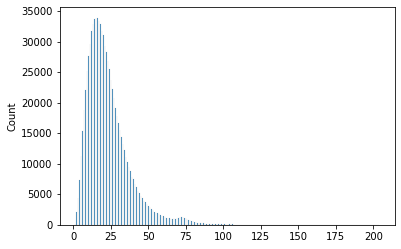

In [20]:
sns.histplot(ru_lens)

In [28]:
800000 / 12

66666.66666666667